# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Source catalogue

## Configuration

### Load libraries and setup

In [1]:
import pickle
import os
import sys
from glob import glob
from shutil import copyfile
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
try:
    BASEPATH = os.path.dirname(os.path.realpath(__file__))
    data_path = os.path.join(BASEPATH, "..", "..", "data")
except NameError:
    if os.path.exists("data"):
        BASEPATH = "."
        data_path = os.path.join(BASEPATH, "data")
    else:
        BASEPATH = os.getcwd()
        data_path = os.path.join(BASEPATH, "..", "..", "data")

In [4]:
sys.path.append(os.path.join(BASEPATH, '..', '..', 'src'))
from mltier1 import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma_all, get_q_m, get_threshold, q0_min_level, q0_min_numbers,
                     get_n_m_kde, estimate_q_m_kde, get_q_m_kde, describe)

In [5]:
%load_ext autoreload

In [6]:
%autoreload

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

### General configuration

In [6]:
save_intermediate = True
plot_intermediate = True

In [9]:
idp = os.path.join(BASEPATH, "..", "..", "data", "idata", "main")

In [10]:
if not os.path.isdir(idp):
    os.makedirs(idp)

### Area limits

In [11]:
field = Field(4.025, 7.08, 27.206, 29.8)

In [20]:
field_full = field
#field_full = Field(160.0, 232.0, 42.0, 62.0)

## Load data

In [13]:
combined_all = Table.read(os.path.join(data_path, "samples", "test_combined.fits"))

We will start to use the updated catalogues that include the output of the LOFAR Galaxy Zoo work.

In [14]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
lofar_all = Table.read(os.path.join(data_path, "samples", "P005p28.fits"))

In [15]:
np.array(combined_all.colnames)

array(['RA', 'DEC', 'UID_L', 'UNWISE_OBJID', 'MAG_R', 'MAG_W1', 'MAG_W2'],
      dtype='<U12')

In [16]:
np.array(lofar_all.colnames)

array(['Source_id', 'Isl_id', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Total_flux',
       'E_Total_flux', 'Peak_flux', 'E_Peak_flux', 'RA_max', 'E_RA_max',
       'DEC_max', 'E_DEC_max', 'Maj', 'E_Maj', 'Min', 'E_Min', 'PA',
       'E_PA', 'Maj_img_plane', 'E_Maj_img_plane', 'Min_img_plane',
       'E_Min_img_plane', 'PA_img_plane', 'E_PA_img_plane', 'DC_Maj',
       'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'DC_PA', 'E_DC_PA',
       'DC_Maj_img_plane', 'E_DC_Maj_img_plane', 'DC_Min_img_plane',
       'E_DC_Min_img_plane', 'DC_PA_img_plane', 'E_DC_PA_img_plane',
       'Isl_Total_flux', 'E_Isl_Total_flux', 'Isl_rms', 'Isl_mean',
       'Resid_Isl_rms', 'Resid_Isl_mean', 'S_Code'], dtype='<U18')

In [17]:
describe(lofar_all['Maj'])

0.003 +/- 0.002; median: 0.002; limits: [0.002, 0.035]; N=5471 (0 NaN; 0 masked)


### Filter catalogues

We will take the sources in the main region but also discard sources with a Major axis size bigger than 30 arsecs. We will also discard all the sources that are not classified with the code 1 in "ID_flag". Henceforth, we only take sources marked as "ML" only.

In [18]:
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]

In [19]:
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.)], 
                               colnames=("RA", "DEC"))

In [21]:
lofar_full = field_full.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.)], 
                                         colnames=("RA", "DEC"))

In [22]:
combined = field.filter_catalogue(combined_all, 
                               colnames=("RA", "DEC"))

### Additional data

In [23]:
combined["colour"] = combined["MAG_R"] - combined["MAG_W1"]

In [24]:
combined_aux_index = np.arange(len(combined))

### Sky coordinates

In [25]:
coords_combined = SkyCoord(combined['RA'], 
                           combined['DEC'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [26]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Class of sources in the combined catalogue

The sources are grouped depending on the available photometric data.

In [27]:
combined_legacy = (~np.isnan(combined["MAG_R"]) & 
                    ~np.isnan(combined["MAG_W1"]) & 
                    ~np.isnan(combined["MAG_W2"])
                   )

In [28]:
combined_wise =(np.isnan(combined["MAG_R"]) & 
                (~np.isnan(combined["MAG_W1"]))
               )

In [29]:
combined_wise2 =(np.isnan(combined["MAG_R"]) & 
                 np.isnan(combined["MAG_W1"]))

In [30]:
print("Total     - ", len(combined))
print("R and W1  - ", np.sum(combined_legacy))
print("Only WISE - ", np.sum(combined_wise))
print("Only W2   - ", np.sum(combined_wise2))

Total     -  547371
R and W1  -  485701
Only WISE -  54618
Only W2   -  7052


### Colour categories

The colour categories will be used after the first ML match

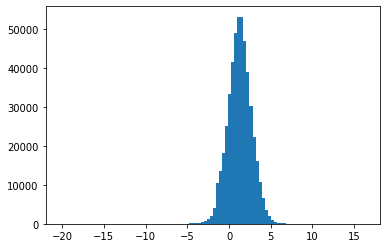

In [33]:
plt.hist(combined["colour"], bins=100);

In [36]:
#from astroML.plotting import hist as amlhist
from astropy.visualization import hist as amlhist

In [50]:
list(range(10,100,10))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [53]:
np.round(np.percentile(combined["colour"][~np.isnan(combined["colour"])], list(range(10,100,10))), 1)

array([-0.5,  0.1,  0.6,  1. ,  1.3,  1.6,  2. ,  2.4,  3.1])

In [54]:
#colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]
colour_limits = np.round(np.percentile(combined["colour"][~np.isnan(combined["colour"])], list(range(10,100,10))), 1)

In [55]:
# Start with the W1-only, i-only and "less than lower colour" bins
colour_bin_def = [{"name":"only W2", "condition": combined_wise2},
                  {"name":"only WISE", "condition": combined_wise},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (combined["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((combined["colour"] >= colour_limits[i]) & 
                 (combined["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (combined["colour"] >= colour_limits[-1])})

/home/jsm/programs/soft/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/jsm/programs/soft/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [56]:
colour_bin_def

[{'name': 'only W2',
  'condition': array([False, False, False, ...,  True,  True,  True])},
 {'name': 'only WISE',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '-inf to -0.5',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '-0.5 to 0.1',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '0.1 to 0.6',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '0.6 to 1.0',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '1.0 to 1.3',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '1.3 to 1.6',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '1.6 to 2.0',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '2.0 to 2.4',
  'condition': array([False,  True,  True, ..., False, False, False])},
 {'name': '2.4 to 3.1',
  'condition': ar

In [57]:
combined["category"] = np.nan
for i in range(len(colour_bin_def)):
    combined["category"][colour_bin_def[i]["condition"]] = i

In [58]:
np.sum(np.isnan(combined["category"]))

0

We get the number of sources of the combined catalogue in each colour category. It will be used at a later stage to compute the $Q_0$ values

In [59]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [60]:
numbers_combined_bins

array([ 7052, 54618, 49495, 43980, 53914, 53200, 43455, 44267, 53846,
       44670, 53165, 45709])

## Description

### Sky coverage

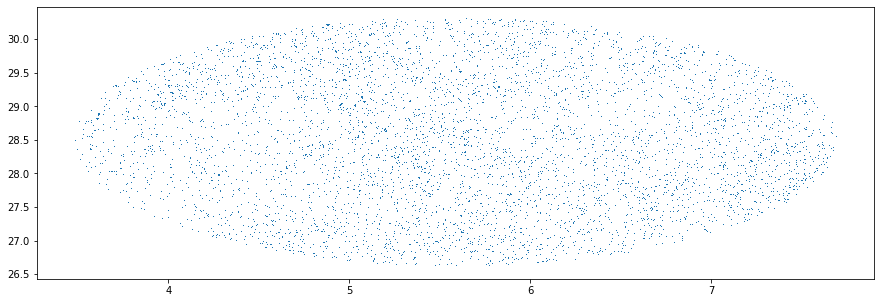

In [62]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(lofar_all["RA"],
     lofar_all["DEC"],
     ls="", marker=",");

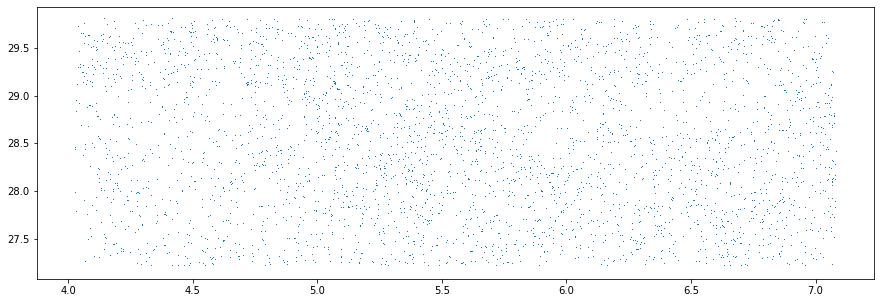

In [63]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(lofar_full["RA"],
     lofar_full["DEC"],
     ls="", marker=",");

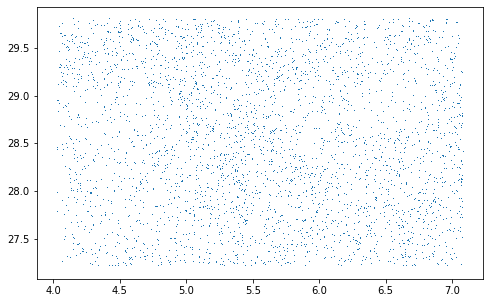

In [64]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(lofar["RA"],
     lofar["DEC"],
     ls="", marker=",");

In [65]:
len(lofar)

3452

### Summary of galaxy types in the combined catalogue

In [66]:
np.sum(combined_legacy) # Matches

485701

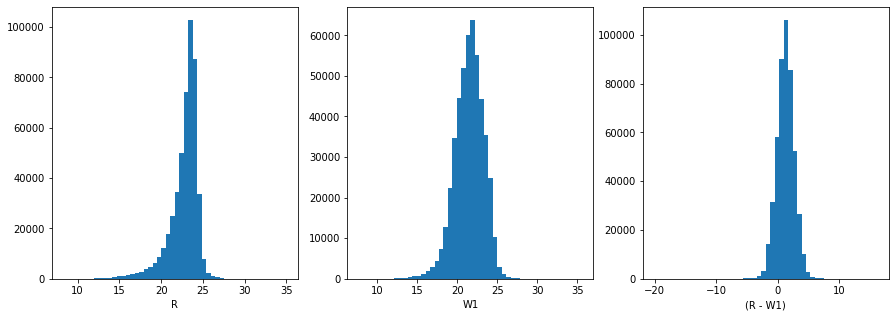

In [68]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.hist(combined["MAG_R"][combined_legacy], bins=50)
plt.xlabel("R")
plt.subplot(1,3,2)
plt.hist(combined["MAG_W1"][combined_legacy], bins=50)
plt.xlabel("W1")
plt.subplot(1,3,3)
plt.hist((combined["MAG_R"] - combined["MAG_W1"])[combined_legacy], bins=50)
plt.xlabel("(R - W1)");

In [69]:
np.sum(combined_wise) # Only WISE

54618

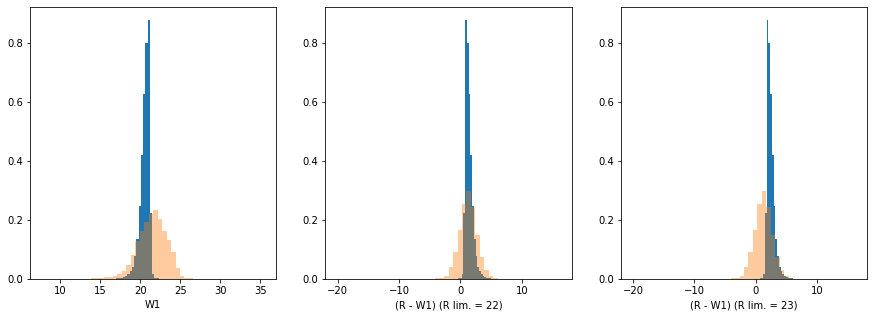

In [74]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.hist(combined["MAG_W1"][combined_wise], bins=50, density=True)
plt.hist(combined["MAG_W1"][combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("W1")
plt.subplot(1,3,2)
plt.hist((22 - combined["MAG_W1"])[combined_wise], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W1"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W1) (R lim. = 22)")
plt.subplot(1,3,3)
plt.hist((23 - combined["MAG_W1"])[combined_wise], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W1"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W1) (R lim. = 23)");

In [75]:
np.sum(combined_wise2) # Only W2

7052

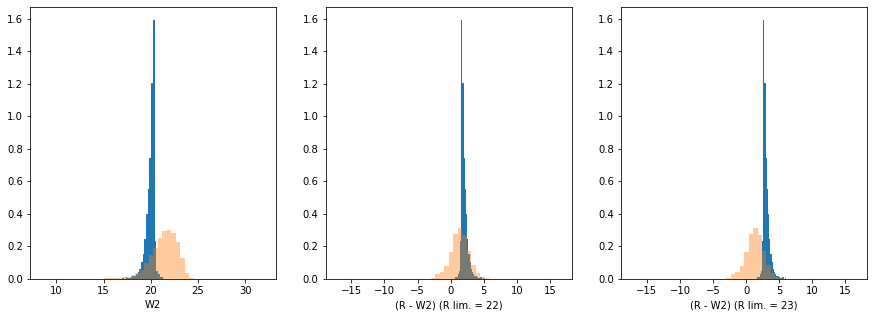

In [76]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.hist(combined["MAG_W2"][combined_wise2], bins=50, density=True)
plt.hist(combined["MAG_W2"][combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("W2")
plt.subplot(1,3,2)
plt.hist((22 - combined["MAG_W2"])[combined_wise2], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W2"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W2) (R lim. = 22)")
plt.subplot(1,3,3)
plt.hist((23 - combined["MAG_W2"])[combined_wise2], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W2"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W2) (R lim. = 23)");

## Maximum Likelihood 1st

### i-band preparation

In [77]:
bandwidth_r = 0.5

In [78]:
catalogue_r = combined[combined_legacy]

In [79]:
bin_list_r = np.linspace(11.5, 29.5, 361) # Bins of 0.05

In [80]:
center_r = get_center(bin_list_r)

In [81]:
n_m_r1 = get_n_m(catalogue_r["MAG_R"], bin_list_r, field.area)

In [82]:
n_m_r = get_n_m_kde(catalogue_r["MAG_R"], center_r, field.area, bandwidth=bandwidth_r)

In [83]:
n_m_r_cs = np.cumsum(n_m_r)

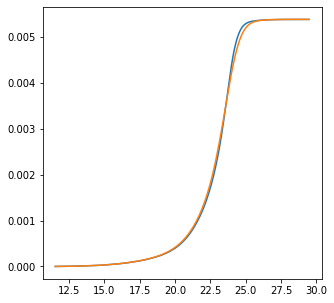

In [84]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_r, n_m_r1);
plt.plot(center_r, n_m_r_cs);

In [85]:
q_m_r1 = estimate_q_m(catalogue_r["MAG_R"], 
                      bin_list_r, 
                      n_m_r1, 
                      coords_lofar, 
                      coords_combined[combined_legacy], 
                      radius=5)

In [86]:
q_m_r = estimate_q_m_kde(catalogue_r["MAG_R"], 
                      center_r, 
                      n_m_r, 
                      coords_lofar, 
                      coords_combined[combined_legacy], 
                      radius=5, 
                      bandwidth=bandwidth_r)

In [87]:
q_m_r_cs = np.cumsum(q_m_r)

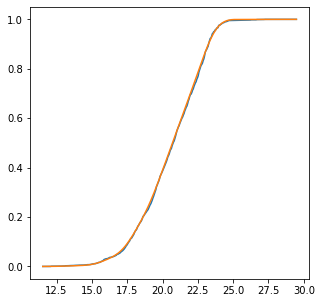

In [88]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_r, q_m_r1);
plt.plot(center_r, q_m_r_cs);

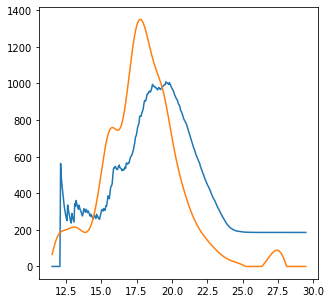

In [90]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_r, q_m_r1/n_m_r1);
plt.plot(center_r, q_m_r/n_m_r);

### W1-band preparation

In [137]:
bandwidth_w1 = 0.5

In [138]:
catalogue_w1 = combined[combined_wise]

In [139]:
bin_list_w1 = np.linspace(11.5, 29.5, 361) # Bins of 0.05

In [140]:
center_w1 = get_center(bin_list_w1)

In [141]:
n_m_w11 = get_n_m(catalogue_w1["MAG_W1"], bin_list_w1, field.area)

In [142]:
n_m_w1 = get_n_m_kde(catalogue_w1["MAG_W1"], center_w1, field.area, bandwidth=bandwidth_w1)

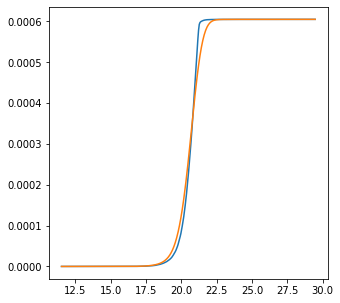

In [143]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_w1, n_m_w11);
plt.plot(center_w1, np.cumsum(n_m_w1));

In [144]:
q_m_w11 = estimate_q_m(catalogue_w1["MAG_W1"], 
                      bin_list_w1, 
                      n_m_w11, coords_lofar, 
                      coords_combined[combined_wise], 
                      radius=5)

In [145]:
q_m_w1 = estimate_q_m_kde(catalogue_w1["MAG_W1"], 
                      center_w1, 
                      n_m_w1, coords_lofar, 
                      coords_combined[combined_wise], 
                      radius=5, 
                      bandwidth=bandwidth_w1)

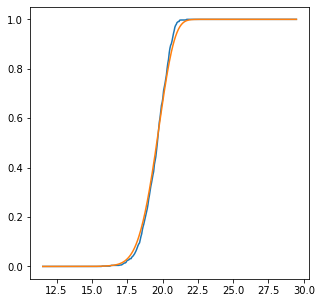

In [146]:
plt.plot(center_w1, q_m_w11);
plt.plot(center_w1, np.cumsum(q_m_w1));

/home/jsm/programs/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


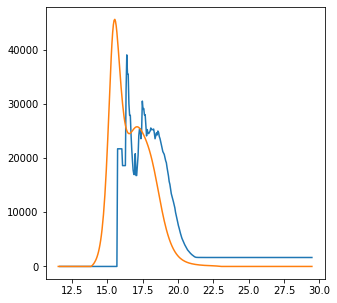

In [147]:
plt.plot(center_w1, q_m_w11/n_m_w11);
plt.plot(center_w1, q_m_w1/n_m_w1);

### W2-band preparation

In [107]:
bandwidth_w2 = 0.5

In [108]:
catalogue_w2 = combined[combined_wise2]

In [128]:
bin_list_w2 = np.linspace(12., 22., 181) # Bins of 0.05

In [129]:
center_w2 = get_center(bin_list_w2)

In [130]:
n_m_w21 = get_n_m(catalogue_w2["MAG_W2"], bin_list_w2, field.area)

In [131]:
n_m_w2 = get_n_m_kde(catalogue_w2["MAG_W2"], center_w2, field.area, bandwidth=bandwidth_w2)

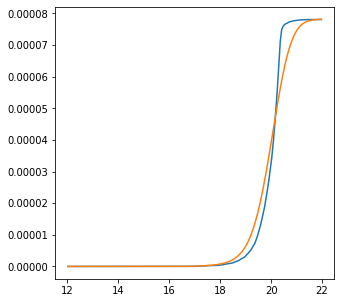

In [132]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_w2, n_m_w21);
plt.plot(center_w2, np.cumsum(n_m_w2));

In [133]:
q_m_w21 = estimate_q_m(catalogue_w2["MAG_W2"], 
                      bin_list_w2, 
                      n_m_w21, coords_lofar, 
                      coords_combined[combined_wise2], 
                      radius=5)

In [134]:
q_m_w2 = estimate_q_m_kde(catalogue_w2["MAG_W2"], 
                      center_w2, 
                      n_m_w2, coords_lofar, 
                      coords_combined[combined_wise2], 
                      radius=5, 
                      bandwidth=bandwidth_w2)

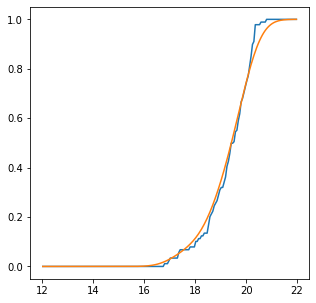

In [135]:
plt.plot(center_w2, q_m_w21);
plt.plot(center_w2, np.cumsum(q_m_w2));

/home/jsm/programs/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


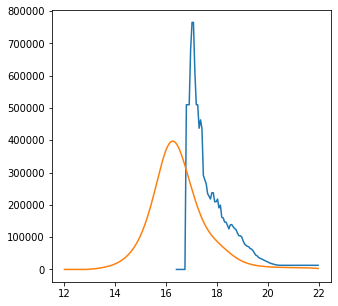

In [136]:
plt.plot(center_w2, q_m_w21/n_m_w21);
plt.plot(center_w2, q_m_w2/n_m_w2);

### $Q_0$ and likelihood estimators

In [150]:
# Initial
Q0_r = 0.67
Q0_w1 = 0.25
Q0_w2 = 0.054

In [151]:
likelihood_ratio_r = SingleMLEstimator(Q0_r, n_m_r, q_m_r, center_r)

In [153]:
likelihood_ratio_w1 = SingleMLEstimator(Q0_w1, n_m_w1, q_m_w1, center_w1)

In [154]:
likelihood_ratio_w2 = SingleMLEstimator(Q0_w2, n_m_w2, q_m_w2, center_w2)

We will get the number of CPUs to use in parallel in the computations

In [155]:
import multiprocessing

In [156]:
n_cpus_total = multiprocessing.cpu_count()

In [157]:
n_cpus = max(1, n_cpus_total-1)

### r-band match

In [158]:
radius = 15

In [159]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_legacy], radius*u.arcsec)

In [160]:
idx_lofar_unique = np.unique(idx_lofar)

In [161]:
lofar["lr_r"] = np.nan                   # Likelihood ratio
lofar["lr_dist_r"] = np.nan              # Distance to the selected source
lofar["lr_index_r"] = np.nan             # Index of the PanSTARRS source in combined

In [162]:
total_sources = len(idx_lofar_unique)
combined_aux_index = np.arange(len(combined))

In [167]:
def ml(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = catalogue_r["MAG_R"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_r["RA"][idx_0]
    c_dec = catalogue_r["DEC"][idx_0]
    c_ra_err = np.ones_like(c_ra)*0.6/3600.
    c_dec_err = np.ones_like(c_ra)*0.6/3600.
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_r(mag, d2d_0.arcsec, sigma_0_0, det_sigma)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_legacy][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [174]:
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook

In [175]:
res = Parallel(n_jobs=n_cpus)(delayed(ml)(i) for i in tqdm_notebook(idx_lofar_unique))

/home/jsm/programs/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [176]:
# # Old version using concurrent futures
# res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

In [180]:
(lofar["lr_index_r"][idx_lofar_unique], 
 lofar["lr_dist_r"][idx_lofar_unique], 
 lofar["lr_r"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for i-band

In [181]:
lofar["lr_r"][np.isnan(lofar["lr_r"])] = 0

In [182]:
threshold_r = np.percentile(lofar["lr_r"], 100*(1 - Q0_r))

In [183]:
threshold_r #4.8 before

0.0001789021661760347

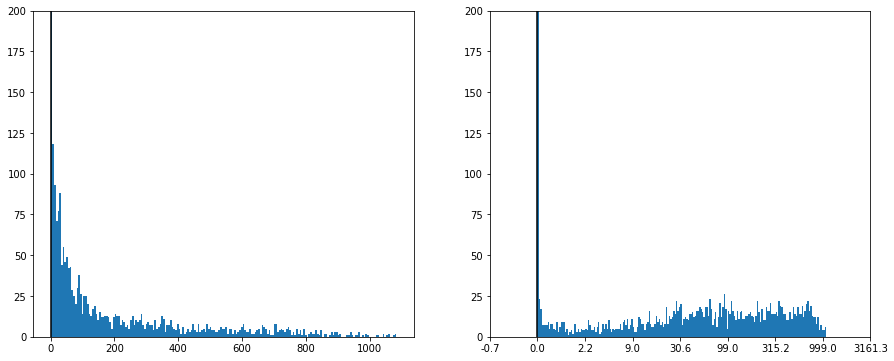

In [188]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_r"] != 0]["lr_r"], bins=200)
plt.vlines([threshold_r], 0, 200)
#plt.ylim([0, 200])
plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_r"] != 0]["lr_r"]+1), bins=200)
plt.vlines(np.log10(threshold_r+1), 0, 200)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
#plt.ylim([0, 200]);

In [93]:
lofar["lr_index_sel_i"] = lofar["lr_index_i"]
lofar["lr_index_sel_i"][lofar["lr_i"] < threshold_i] = np.nan

### W1-band match

In [189]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_wise], radius*u.arcsec)

In [190]:
idx_lofar_unique = np.unique(idx_lofar)

In [191]:
lofar["lr_w1"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w1"] = np.nan              # Distance to the selected source
lofar["lr_index_w1"] = np.nan             # Index of the PanSTARRS source in combined

In [196]:
def ml_w1(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = catalogue_w1["MAG_W1"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_w1["RA"][idx_0]
    c_dec = catalogue_w1["DEC"][idx_0]
    c_ra_err = np.ones_like(c_ra)*0.6/3600.
    c_dec_err = np.ones_like(c_ra)*0.6/3600.
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_w1(mag, d2d_0.arcsec, sigma_0_0, det_sigma)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_wise][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [197]:
#res = parallel_process(idx_lofar_unique, ml_w1, n_jobs=n_cpus)
res = Parallel(n_jobs=n_cpus)(delayed(ml_w1)(i) for i in tqdm_notebook(idx_lofar_unique))

/home/jsm/programs/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [198]:
(lofar["lr_index_w1"][idx_lofar_unique], 
 lofar["lr_dist_w1"][idx_lofar_unique], 
 lofar["lr_w1"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for W1 band

In [199]:
lofar["lr_w1"][np.isnan(lofar["lr_w1"])] = 0

In [200]:
threshold_w1 = np.percentile(lofar["lr_w1"], 100*(1 - Q0_w1))

In [201]:
threshold_w1 # 0.695 before

2.733938498860747e-20

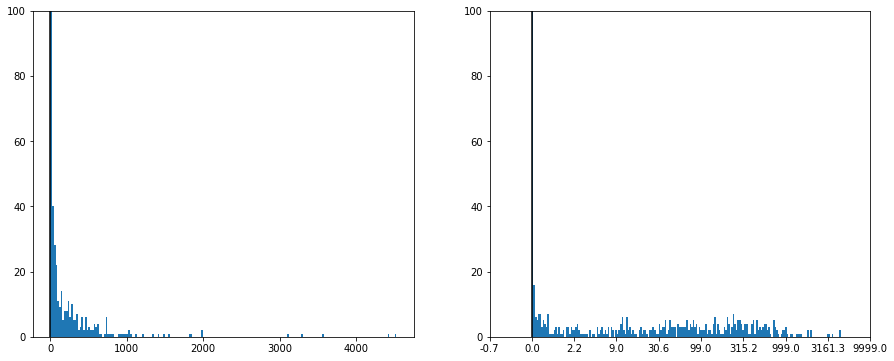

In [203]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_w1"] != 0]["lr_w1"], bins=200)
plt.vlines([threshold_w1], 0, 100)
plt.ylim([0,100])
plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_w1"] != 0]["lr_w1"]+1), bins=200)
plt.vlines(np.log10(threshold_w1+1), 0, 100)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,100]);

In [204]:
lofar["lr_index_sel_w1"] = lofar["lr_index_w1"]
lofar["lr_index_sel_w1"][lofar["lr_w1"] < threshold_w1] = np.nan

### W2-band match

In [205]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_wise2], radius*u.arcsec)

In [206]:
idx_lofar_unique = np.unique(idx_lofar)

In [207]:
lofar["lr_w2"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w2"] = np.nan              # Distance to the selected source
lofar["lr_index_w2"] = np.nan             # Index of the PanSTARRS source in combined

In [208]:
def ml_w2(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = catalogue_w2["MAG_W2"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_w1["RA"][idx_0]
    c_dec = catalogue_w1["DEC"][idx_0]
    c_ra_err = np.ones_like(c_ra)*0.6/3600.
    c_dec_err = np.ones_like(c_ra)*0.6/3600.
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_w2(mag, d2d_0.arcsec, sigma_0_0, det_sigma)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_wise2][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [209]:
#res = parallel_process(idx_lofar_unique, ml_w1, n_jobs=n_cpus)
res = Parallel(n_jobs=n_cpus)(delayed(ml_w2)(i) for i in tqdm_notebook(idx_lofar_unique))

/home/jsm/programs/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [210]:
(lofar["lr_index_w2"][idx_lofar_unique], 
 lofar["lr_dist_w2"][idx_lofar_unique], 
 lofar["lr_w2"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for W1 band

In [211]:
lofar["lr_w2"][np.isnan(lofar["lr_w2"])] = 0

In [212]:
threshold_w2 = np.percentile(lofar["lr_w2"], 100*(1 - Q0_w1))

In [213]:
threshold_w2 # 0.695 before

0.0

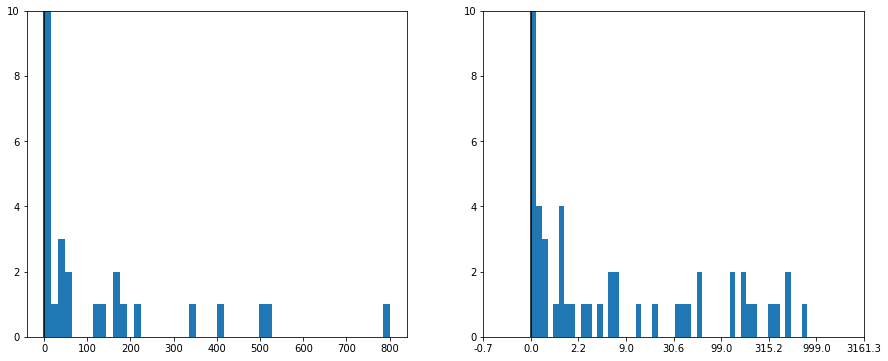

In [216]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_w2"] != 0]["lr_w2"], bins=50)
plt.vlines([threshold_w2], 0, 10)
plt.ylim([0,10])
plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_w2"] != 0]["lr_w2"]+1), bins=50)
plt.vlines(np.log10(threshold_w2+1), 0, 10)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,10]);

In [217]:
lofar["lr_index_sel_w2"] = lofar["lr_index_w2"]
lofar["lr_index_sel_w2"][lofar["lr_w2"] < threshold_w2] = np.nan

### Final selection of the match

We combine the ML matching done in i-band and W1-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [106]:
# lr_i_and_w1 = (lofar["lr_i"] != 0) & (lofar["lr_w1"] != 0)
# lr_only_i = (lofar["lr_i"] != 0) & (lofar["lr_w1"] == 0)
# lr_only_w1 = (lofar["lr_i"] == 0) & (lofar["lr_w1"] != 0)
# lr_no_match = (lofar["lr_i"] == 0) & (lofar["lr_w1"] == 0)
lr_i_and_w1 = ~np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_only_i = ~np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])
lr_only_w1 = np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_no_match = np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])

In [107]:
print(np.sum(lr_i_and_w1))
print(np.sum(lr_only_i))
print(np.sum(lr_only_w1))
print(np.sum(lr_no_match))

43470
3292
20462
24108


In [105]:
print(np.sum(lr_i_and_w1))
print(np.sum(lr_only_i))
print(np.sum(lr_only_w1))
print(np.sum(lr_no_match))

43425
3337
20507
24063


In [108]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [109]:
# Only i matches
lofar["lr_1"][lr_only_i] = lofar["lr_i"][lr_only_i]
lofar["lr_index_1"][lr_only_i] = lofar["lr_index_i"][lr_only_i]
lofar["lr_dist_1"][lr_only_i] = lofar["lr_dist_i"][lr_only_i]
lofar["lr_type_1"][lr_only_i] = 1

# Only w1 matches
lofar["lr_1"][lr_only_w1] = lofar["lr_w1"][lr_only_w1]
lofar["lr_index_1"][lr_only_w1] = lofar["lr_index_w1"][lr_only_w1]
lofar["lr_dist_1"][lr_only_w1] = lofar["lr_dist_w1"][lr_only_w1]
lofar["lr_type_1"][lr_only_w1] = 2

# Both matches
lofar["lr_1"][lr_i_and_w1] = np.max([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0)
lofar["lr_type_1"][lr_i_and_w1] = np.argmax([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0) + 1

c1 = (lofar["lr_type_1"] == 1)
c2 = (lofar["lr_type_1"] == 2)
lofar["lr_index_1"][lr_i_and_w1 & c1] = lofar["lr_index_i"][lr_i_and_w1 & c1]
lofar["lr_index_1"][lr_i_and_w1 & c2] = lofar["lr_index_w1"][lr_i_and_w1 & c2]
lofar["lr_dist_1"][lr_i_and_w1 & c1] = lofar["lr_dist_i"][lr_i_and_w1 & c1]
lofar["lr_dist_1"][lr_i_and_w1 & c2] = lofar["lr_dist_w1"][lr_i_and_w1 & c2]

Summary of the number of sources matches of each type

In [110]:
print("match    sel-i: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match   sel-W1: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match   i-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match  W1-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

match    sel-i:  1723
match   sel-W1:  41747
match     both:  43470
match   i-only:  3292
match  W1-only:  20462
match      all:  67224
         Total:  91332


In [108]:
print("match    sel-i: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match   sel-W1: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match   i-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match  W1-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

match    sel-i:  1330
match   sel-W1:  42095
match     both:  43425
match   i-only:  3337
match  W1-only:  20507
match      all:  67269
         Total:  91332


The number of sources for which the match in i-band and W1-band are above the threshold but gives a different match to the combined catalogue.

In [111]:
print(np.sum(lofar["lr_index_i"][lr_i_and_w1] != lofar["lr_index_w1"][lr_i_and_w1]))

1404


#### Duplicated sources

This is the nymber of sources of the combined catalogue that are combined to multiple LOFAR sources. In the case of the catalogue of Gaussians the number can be very high.

In [112]:
values, counts = np.unique(lofar[lofar["lr_type_1"] != 0]["lr_index_1"], return_counts=True)

In [113]:
len(values[counts > 1])

6

In [114]:
n_dup, n_sour = np.unique(counts[counts > 1], return_counts=True)

Text(0,0.5,'Number of sources in the category')

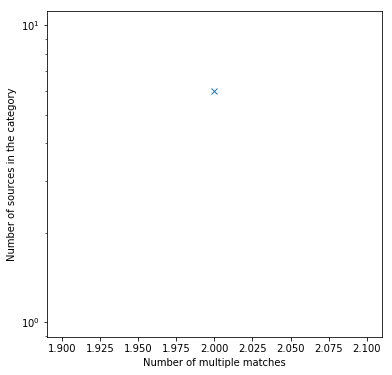

In [115]:
plt.rcParams["figure.figsize"] = (6,6)
semilogy(n_dup, n_sour, marker="x")
xlabel("Number of multiple matches")
ylabel("Number of sources in the category")

### Save intermediate data

In [116]:
if save_intermediate:
    pickle.dump([bin_list_i, center_i, Q0_i, n_m_i1, q_m_i1], 
                open("{}/lofar_params_cumsum_1i.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w11, q_m_w11], 
                open("{}/lofar_params_cumsum_1w1.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_i, center_i, Q0_i, n_m_i, q_m_i], 
                open("{}/lofar_params_1i.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w1, q_m_w1], 
                open("{}/lofar_params_1w1.pckl".format(idp), 'wb'))
    lofar.write("{}/lofar_m1.fits".format(idp), format="fits")

## Second iteration using colour

From now on we will take into account the effect of the colour. The sample was distributed in several categories according to the colour of the source and this is considered here.

### Rusable parameters for all the iterations

These parameters are derived from the underlying population and will not change.

First we compute the number of galaxies in each bin for the combined catalogue

In [117]:
bin_list = [bin_list_w1 if i == 0 else bin_list_i for i in range(len(colour_bin_def))]
centers = [center_w1 if i == 0 else center_i for i in range(len(colour_bin_def))]

In [118]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [119]:
numbers_combined_bins

array([ 669839, 1778426,  123221,   86953,  127155,   91489,  106076,
        112638,  109949,   98183,   81055,   61913,   44390,   46507,
         14347,    5536])

Get the colour category and magnitudes for the matched LOFAR sources

In [120]:
bandwidth_colour = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [121]:
n_m = []

# W1 only sources
n_m.append(get_n_m_kde(combined["W1mag"][combined["category"] == 0], 
                       centers[0], field.area, bandwidth=bandwidth_colour[0]))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m.append(get_n_m_kde(combined["i"][combined["category"] == i], 
                           centers[i], field.area, bandwidth=bandwidth_colour[i]))

In [122]:
n_m_old = []

# W1 only sources
n_m_old.append(get_n_m(combined["W1mag"][combined["category"] == 0], bin_list_w1, field.area))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m_old.append(get_n_m(combined["i"][combined["category"] == i], bin_list_i, field.area))

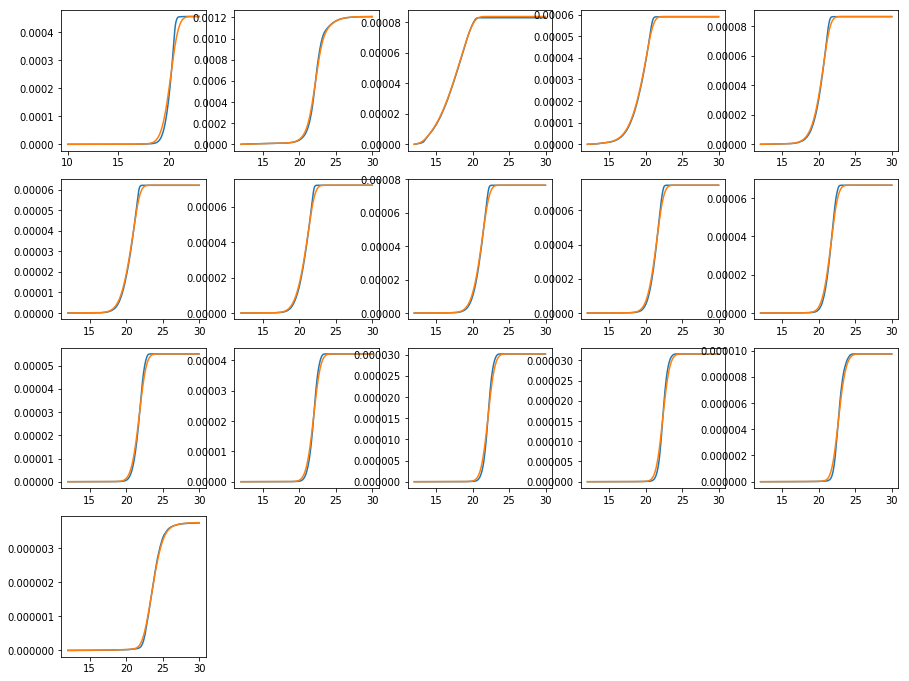

In [123]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m):
    subplot(5,5,i+1)
    plot(centers[i], n_m_old[i])
    plot(centers[i], np.cumsum(n_m_k))

### Parameters of the matched sample

The parameters derived from the matched LOFAR galaxies: $q_0$, q(m) and the number of sources per category.

The columns "category", "W1mag" and "i" will contain the properties of the matched galaxies and will be updated in each iteration to save space.

In [124]:
lofar["category"] = np.nan
lofar["W1mag"] = np.nan
lofar["i"] = np.nan

In [125]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["W1mag"][c] = combined[indices]["W1mag"]
lofar["i"][c] = combined[indices]["i"]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [126]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [127]:
numbers_lofar_combined_bins

array([19330,  3993,   234,   569,  2325,  3281,  4703,  5232,  5029,
        4553,  4342,  3819,  3287,  4336,  1662,   529])

The $Q_0$ for each category are obtained by dividing the number of sources in the category by the total number of sources in the sample.

In [128]:
Q_0_colour = numbers_lofar_combined_bins/len(lofar) ### Q_0

In [129]:
q0_total = np.sum(Q_0_colour)

In [130]:
q0_total

0.7360399421889371

The q(m) is not estimated with the method of Fleuren et al. but with the most updated distributions and numbers for the matches.

In [131]:
q_m_old = []
radius = 15. 

# W1 only sources
q_m_old.append(get_q_m(lofar["W1mag"][lofar["category"] == 0], 
                   bin_list_w1, 
                   numbers_lofar_combined_bins[0], 
                   n_m_old[0], 
                   field.area, 
                   radius=radius))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m_old.append(get_q_m(lofar["i"][lofar["category"] == i], 
                   bin_list_i, 
                   numbers_lofar_combined_bins[i], 
                   n_m_old[i], 
                   field.area, 
                   radius=radius))

In [132]:
q_m = []
radius = 15. 

# W1 only sources
q_m.append(get_q_m_kde(lofar["W1mag"][lofar["category"] == 0], 
                   centers[0], 
                   radius=radius,
                   bandwidth=bandwidth_colour[0]))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m_kde(lofar["i"][lofar["category"] == i], 
                   centers[i], 
                   radius=radius,
                   bandwidth=bandwidth_colour[i]))

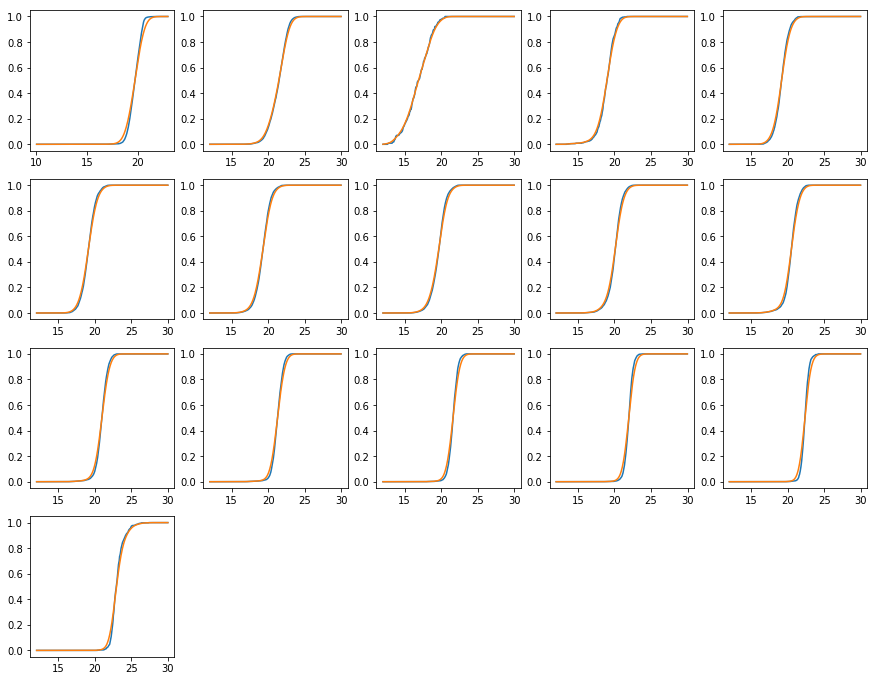

In [133]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    subplot(5,5,i+1)
    plot(centers[i], q_m_old[i])
    plot(centers[i], np.cumsum(q_m_k))

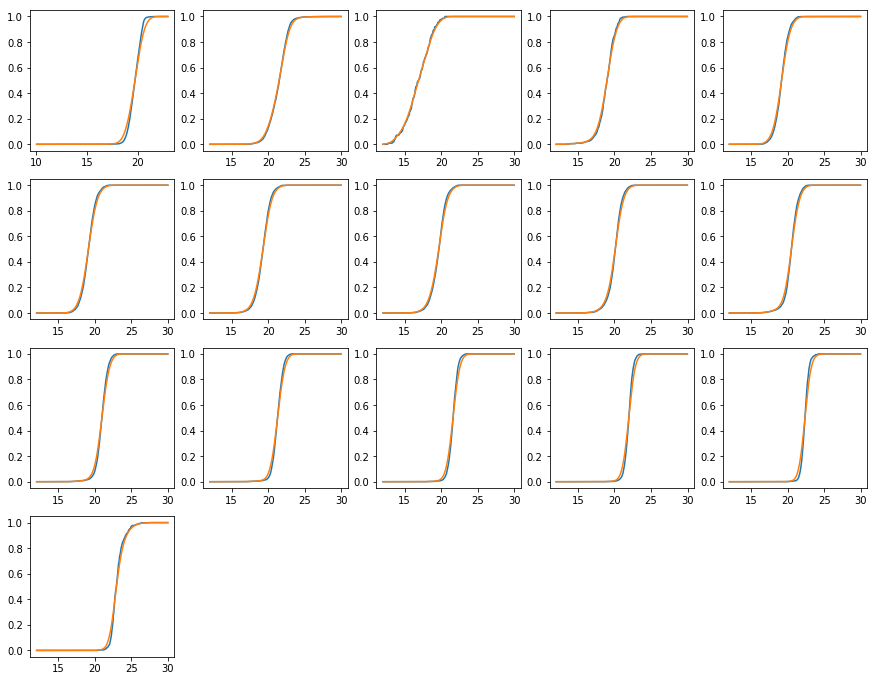

In [131]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    subplot(5,5,i+1)
    plot(centers[i], q_m_old[i])
    plot(centers[i], np.cumsum(q_m_k))

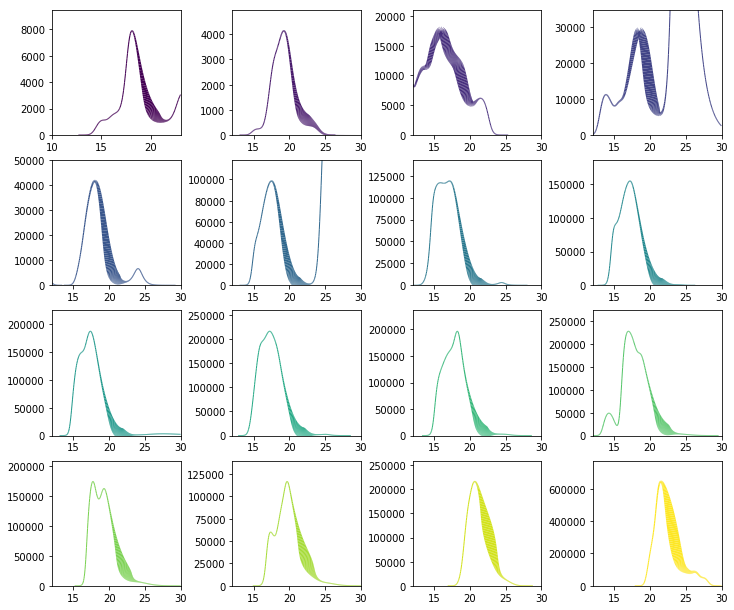

In [134]:
plt.rcParams["figure.figsize"] = (12,10)

from matplotlib import cm
from matplotlib.collections import LineCollection

cm_subsection = linspace(0., 1., 16) 
colors = [ cm.viridis(x) for x in cm_subsection ]

low = np.nonzero(centers[1] >= 15)[0][0]
high = np.nonzero(centers[1] >= 22.2)[0][0]

fig, a = plt.subplots()

for i, q_m_k in enumerate(q_m):
    #plot(centers[i], q_m_old[i]/n_m_old[i])
    a = subplot(4,4,i+1)
    if i not in [-1]:
        n_m_aux = n_m[i]/np.sum(n_m[i])
        lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
        #print(lwidths)
        
        y_aux = q_m_k/n_m[i]
        factor = np.max(y_aux[low:high])
        y = y_aux
        #print(y)
        x = centers[i]
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, linewidths=lwidths, color=colors[i])
        
        a.add_collection(lc)
        
        #plot(centers[i], x/factor, color=colors[i-1])
        xlim([12, 30])
        if i == 0:
            xlim([10, 23])
        ylim([0, 1.2*factor])

subplots_adjust(left=0.125, 
                bottom=0.1, 
                right=0.9, 
                top=0.9,
                wspace=0.4, 
                hspace=0.2)

* https://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib
* https://stackoverflow.com/questions/19390895/matplotlib-plot-with-variable-line-width
* https://stackoverflow.com/questions/432112/is-there-a-numpy-function-to-return-the-first-index-of-something-in-an-array

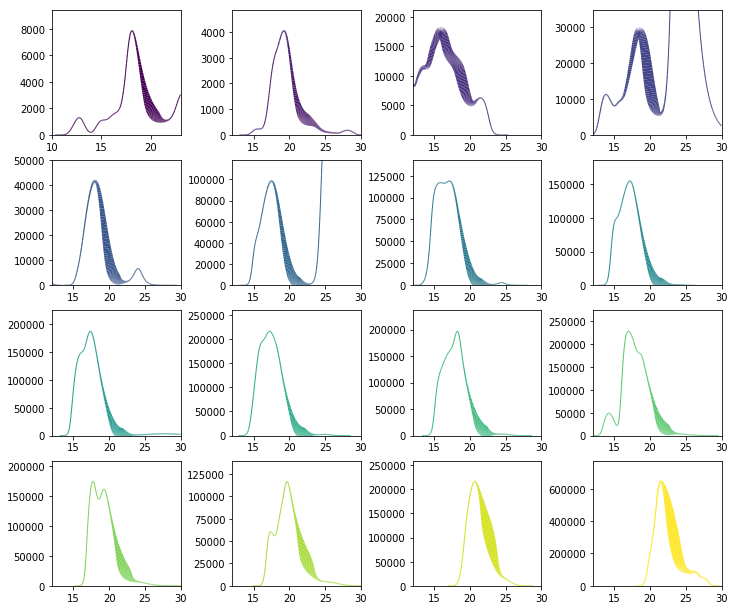

In [156]:
plt.rcParams["figure.figsize"] = (12,10)

from matplotlib import cm
from matplotlib.collections import LineCollection

cm_subsection = linspace(0., 1., 16) 
colors = [ cm.viridis(x) for x in cm_subsection ]

low = np.nonzero(centers[1] >= 15)[0][0]
high = np.nonzero(centers[1] >= 22.2)[0][0]

fig, a = plt.subplots()

for i, q_m_k in enumerate(q_m):
    #plot(centers[i], q_m_old[i]/n_m_old[i])
    a = subplot(4,4,i+1)
    if i not in [-1]:
        n_m_aux = n_m[i]/np.sum(n_m[i])
        lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
        #print(lwidths)
        
        y_aux = q_m_k/n_m[i]
        factor = np.max(y_aux[low:high])
        y = y_aux
        #print(y)
        x = centers[i]
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, linewidths=lwidths, color=colors[i])
        
        a.add_collection(lc)
        
        #plot(centers[i], x/factor, color=colors[i-1])
        xlim([12, 30])
        if i == 0:
            xlim([10, 23])
        ylim([0, 1.2*factor])

subplots_adjust(left=0.125, 
                bottom=0.1, 
                right=0.9, 
                top=0.9,
                wspace=0.4, 
                hspace=0.2)

### Save intermediate parameters

In [135]:
if save_intermediate:
    pickle.dump([bin_list, centers, Q_0_colour, n_m_old, q_m_old], 
                open("{}/lofar_params_cumsum_2.pckl".format(idp), 'wb'))
    pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                open("{}/lofar_params_2.pckl".format(idp), 'wb'))

### Prepare for ML

In [136]:
selection = ~np.isnan(combined["category"]) # Avoid the two dreaded sources with no actual data
catalogue = combined[selection]

In [137]:
radius = 15

In [138]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["i"][idx_0]
    mag[category == 0] = catalogue["W1mag"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = catalogue["raErr"][idx_0]
    c_dec_err = catalogue["decErr"][idx_0]
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, sigma_maj, sigma_min, category)
    
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

### Run the cross-match

This will not need to be repeated after

In [139]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[selection], radius*u.arcsec)

In [140]:
idx_lofar_unique = np.unique(idx_lofar)

### Run the ML matching

In [141]:
likelihood_ratio = MultiMLEstimatorU(Q_0_colour, n_m, q_m, centers)

In [142]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [143]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 87.9k/87.9k [05:54<00:00, 248it/s]
100%|██████████| 87863/87863 [00:00<00:00, 386077.13it/s]


In [144]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan

In [145]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

Get the new threshold for the ML matching. FIX THIS

In [146]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

In [147]:
threshold = np.percentile(lofar["lr_2"], 100*(1 - q0_total))
#manual_q0 = 0.65
#threshold = np.percentile(lofar["lr_2"], 100*(1 - manual_q0))

In [148]:
threshold # Old: 0.69787

0.7168394527247878

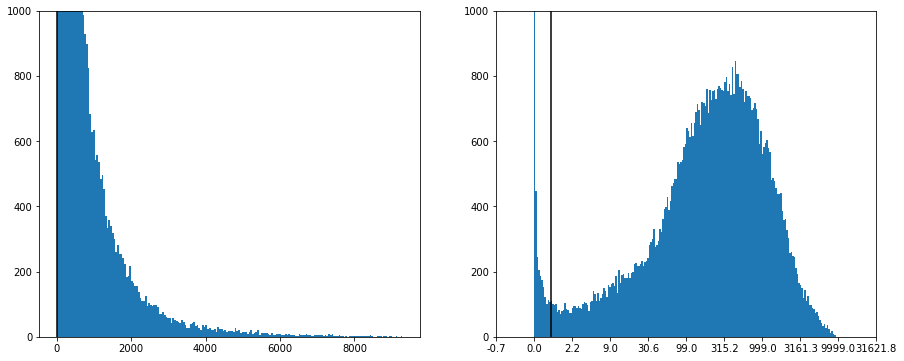

In [171]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
vlines([threshold], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
vlines(np.log10(threshold+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [154]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [155]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))

In [174]:
n_changes # Old: 382

382

Enter the results

In [157]:
# Clear aux columns
lofar["category"] = np.nan
lofar["W1mag"] = np.nan
lofar["i"] = np.nan

c = ~np.isnan(lofar["lr_index_sel_2"])
indices = lofar["lr_index_sel_2"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["W1mag"][c] = combined[indices]["W1mag"]
lofar["i"][c] = combined[indices]["i"]

In [158]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [177]:
numbers_lofar_combined_bins

array([19576,  3768,   111,   520,  2295,  3281,  4699,  5246,  5053,
        4567,  4369,  3851,  3312,  4403,  1679,   539])

### Save intermediate data

In [160]:
if save_intermediate:
    lofar.write("{}/lofar_m2.fits".format(idp), format="fits")

## Iterate until convergence

In [161]:
rerun_iter = False

In [185]:
if rerun_iter:
    lofar = Table.read("{}/lofar_m2.fits".format(idp))
    bin_list, centers, Q_0_colour, n_m, q_m = pickle.load(open("{}/lofar_params_2.pckl".format(idp), 'rb'))
    inter_data_list = glob("{}/lofar_m*.fits".format(idp))
    # Remove data
    for inter_data_file in inter_data_list:
        if inter_data_file[-7:-5] not in ["m1", "m2"]:
            #print(inter_data_file)
            os.remove(inter_data_file)
    # Remove images
    images_list = glob("{}/*.png".format(idp))
    for images in images_list:
        #print(images)
        os.remove(images)
    # Remove parameters
    inter_param_list = glob("{}/lofar_params_*.pckl".format(idp))
    for inter_param_file in inter_param_list:
        if inter_param_file[-7:-5] not in ["1i", "w1", "_2"]:
            #print(inter_param_file)
            os.remove(inter_param_file)

In [163]:
radius = 15. 

In [164]:
from matplotlib import pyplot as plt

In [165]:
def plot_q_n_m(q_m, n_m):
    fig, a = plt.subplots()

    for i, q_m_k in enumerate(q_m):
        #plot(centers[i], q_m_old[i]/n_m_old[i])
        a = subplot(4,4,i+1)
        if i not in [-1]:
            n_m_aux = n_m[i]/np.sum(n_m[i])
            lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
            #print(lwidths)

            y_aux = q_m_k/n_m[i]
            factor = np.max(y_aux[low:high])
            y = y_aux
            #print(y)
            x = centers[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments, linewidths=lwidths, color=colors[i])

            a.add_collection(lc)

            #plot(centers[i], x/factor, color=colors[i-1])
            xlim([12, 30])
            if i == 0:
                xlim([10, 23])
            ylim([0, 1.2*factor])

    subplots_adjust(left=0.125, 
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.2)
    return fig

Iteration 3
numbers_lofar_combined_bins
[19576  3768   111   520  2295  3281  4699  5246  5053  4567  4369  3851
  3312  4403  1679   539]
Q_0_colour
[0.2143389  0.04125608 0.00121535 0.00569351 0.0251281  0.03592388
 0.05144966 0.05743879 0.05532563 0.05000438 0.04783646 0.04216485
 0.0362633  0.04820873 0.01838348 0.00590155]
Q_0_total:  0.7365326501116805


100%|██████████| 87.9k/87.9k [05:54<00:00, 248it/s]
100%|██████████| 87863/87863 [00:00<00:00, 385998.68it/s]


Threshold:  0.671539055471364
N changes:  13
T changes:  24104
******** continue **********
Iteration 4
numbers_lofar_combined_bins
[19598  3745    95   519  2295  3282  4699  5248  5054  4570  4371  3851
  3313  4409  1680   540]
Q_0_colour
[0.21457977 0.04100425 0.00104016 0.00568256 0.0251281  0.03593483
 0.05144966 0.05746069 0.05533657 0.05003723 0.04785836 0.04216485
 0.03627425 0.04827443 0.01839443 0.0059125 ]
Q_0_total:  0.7365326501116805


100%|██████████| 87.9k/87.9k [05:51<00:00, 250it/s]
100%|██████████| 87863/87863 [00:00<00:00, 396115.99it/s]


Threshold:  0.6669766687372396
N changes:  3
T changes:  24074
******** continue **********
Iteration 5
numbers_lofar_combined_bins
[19604  3743    88   519  2295  3282  4699  5248  5055  4570  4371  3851
  3314  4410  1680   540]
Q_0_colour
[0.21464547 0.04098235 0.001      0.00568256 0.0251281  0.03593483
 0.05144966 0.05746069 0.05534752 0.05003723 0.04785836 0.04216485
 0.0362852  0.04828538 0.01839443 0.0059125 ]
Q_0_total:  0.7365691323960933


100%|██████████| 87.9k/87.9k [05:55<00:00, 247it/s]
100%|██████████| 87863/87863 [00:00<00:00, 397191.00it/s]


Threshold:  0.6636222443922981
N changes:  0
T changes:  24067


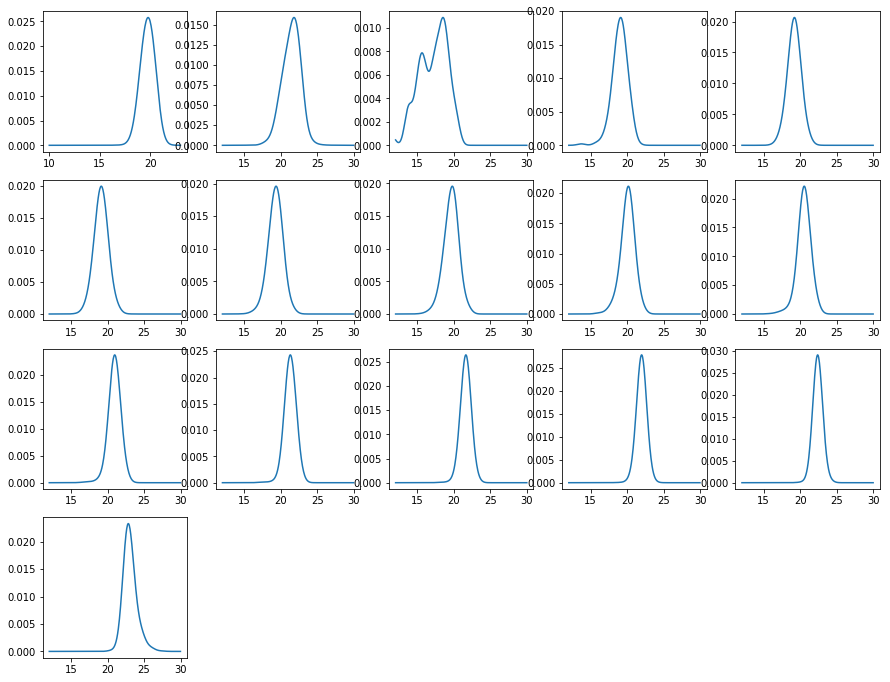

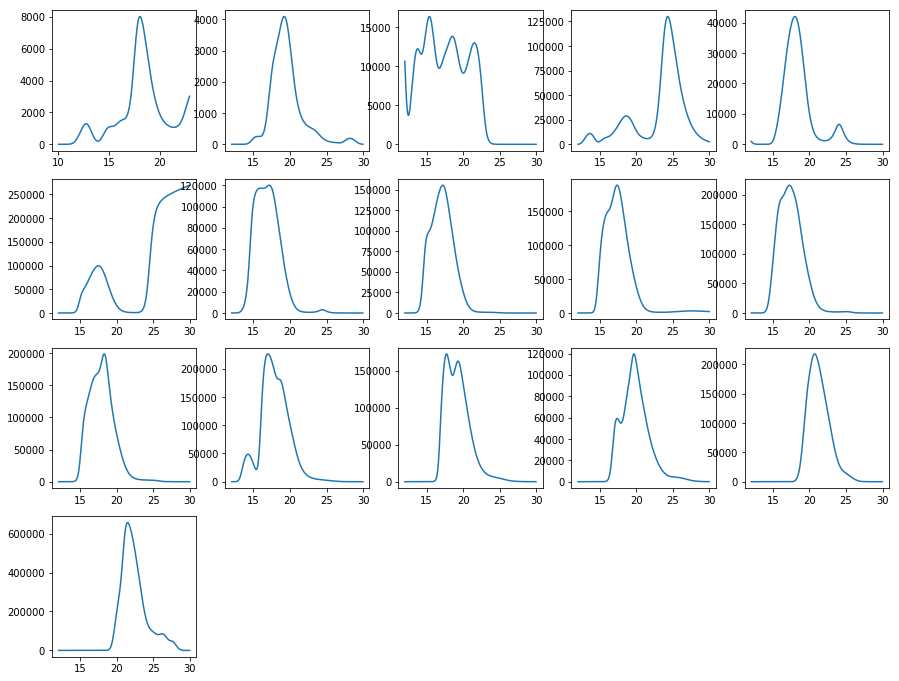

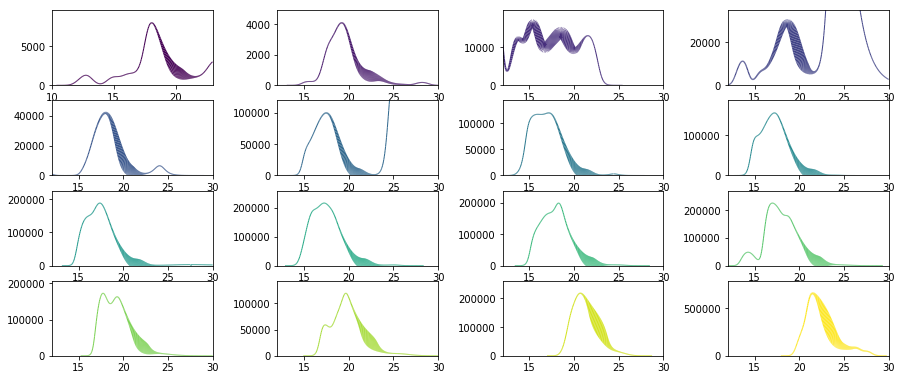

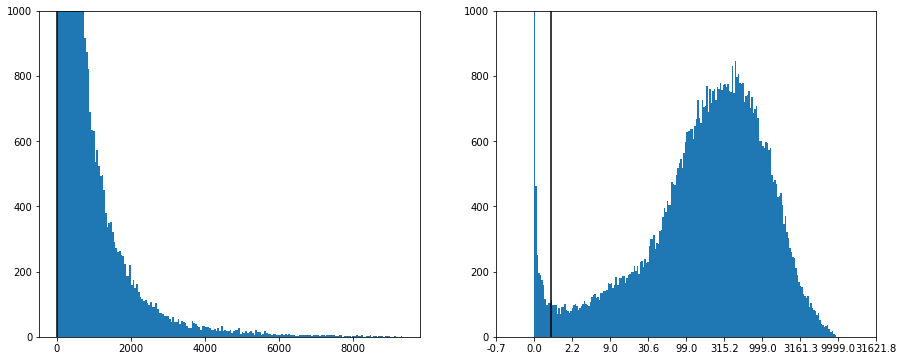

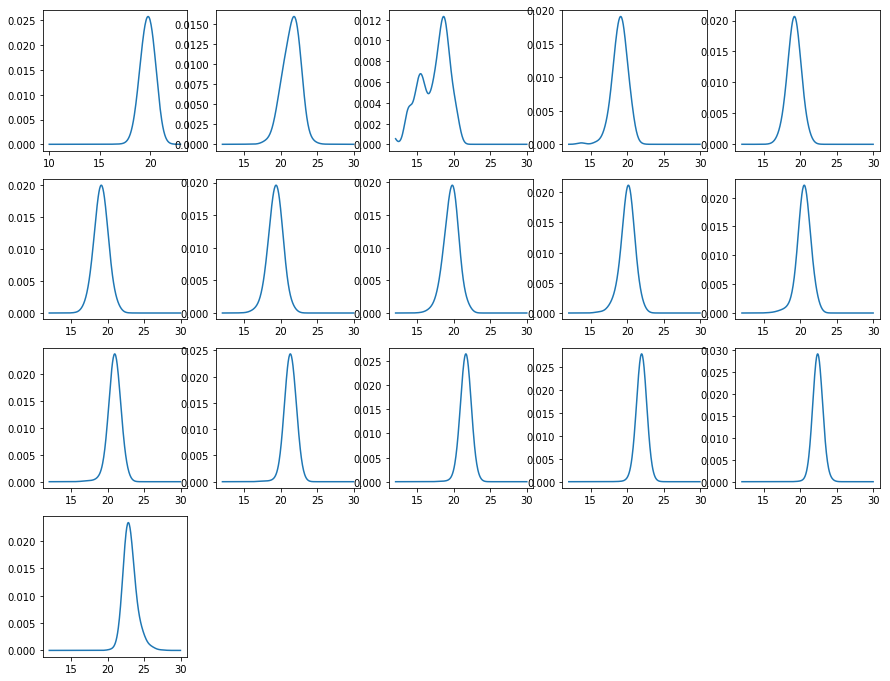

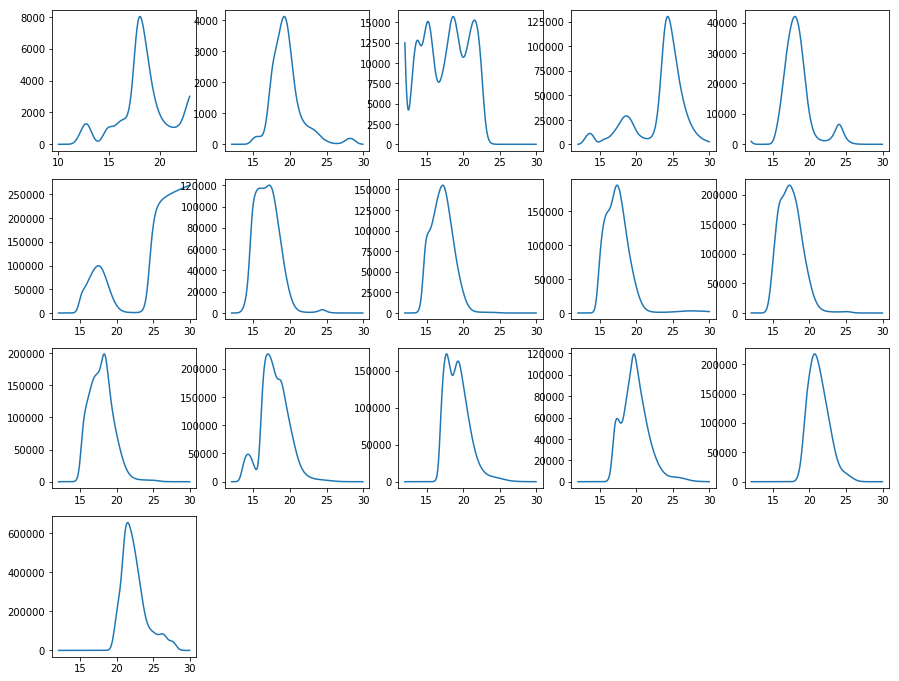

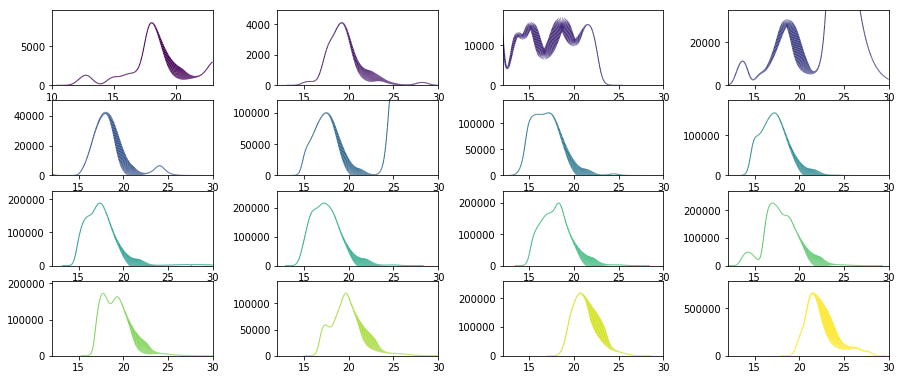

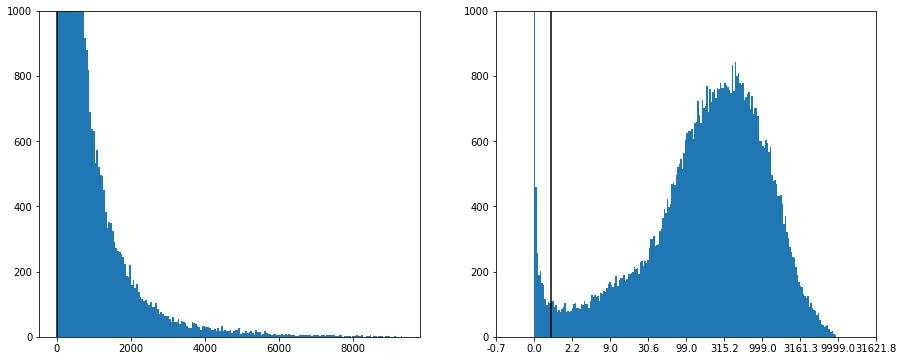

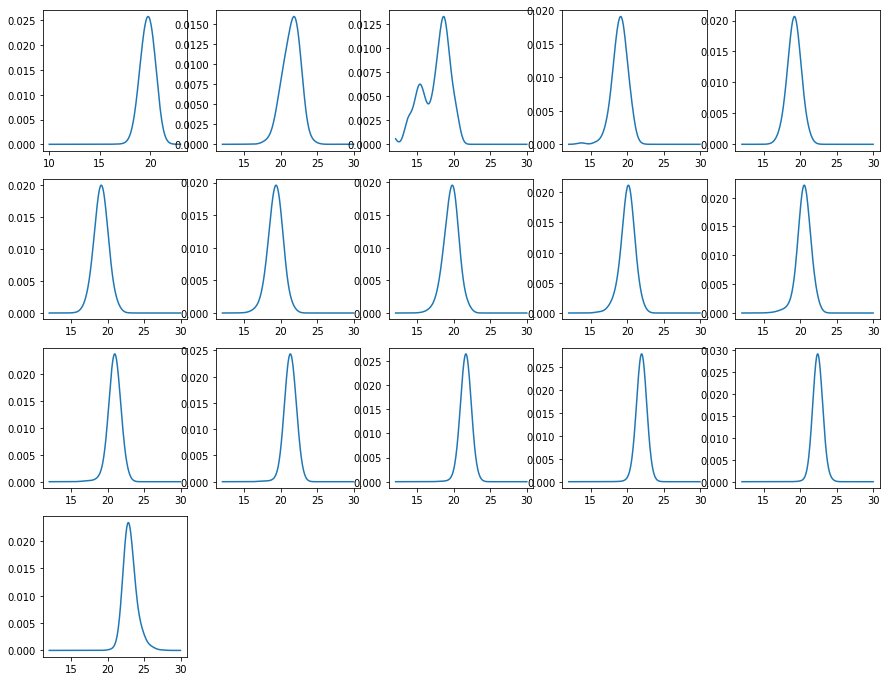

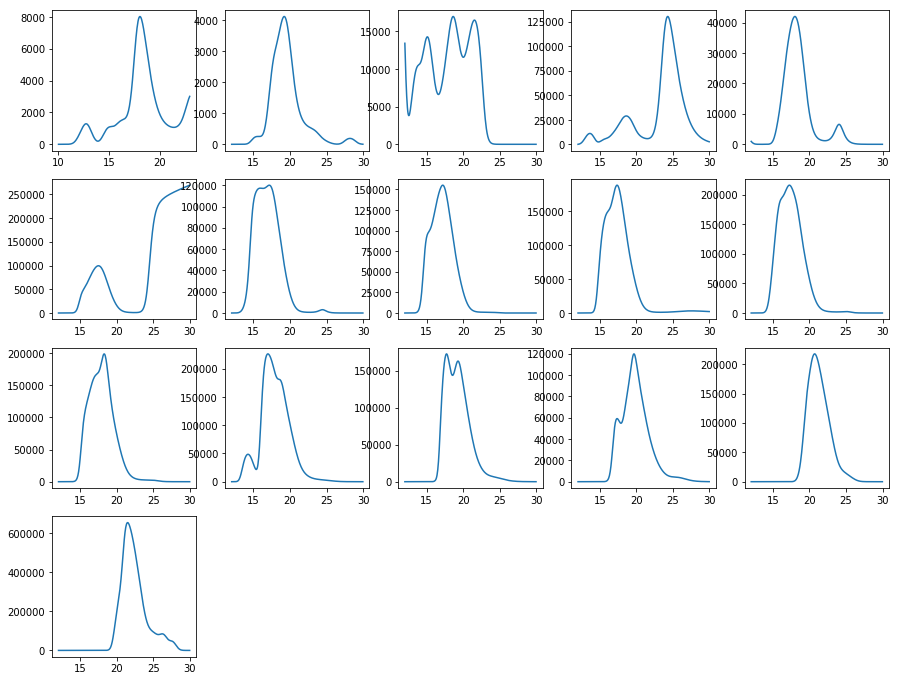

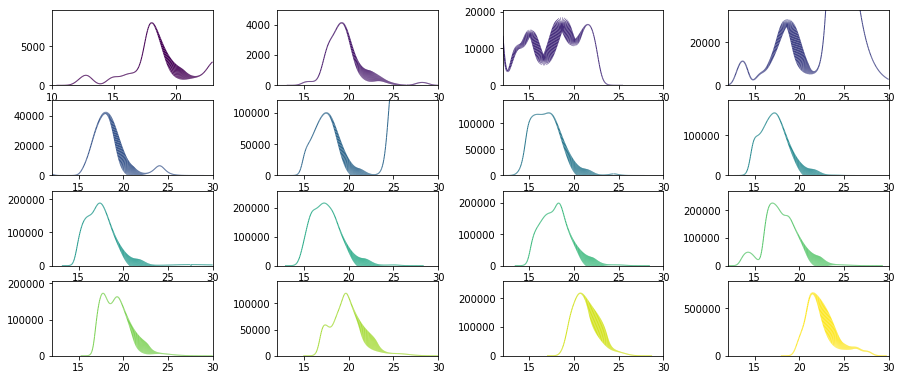

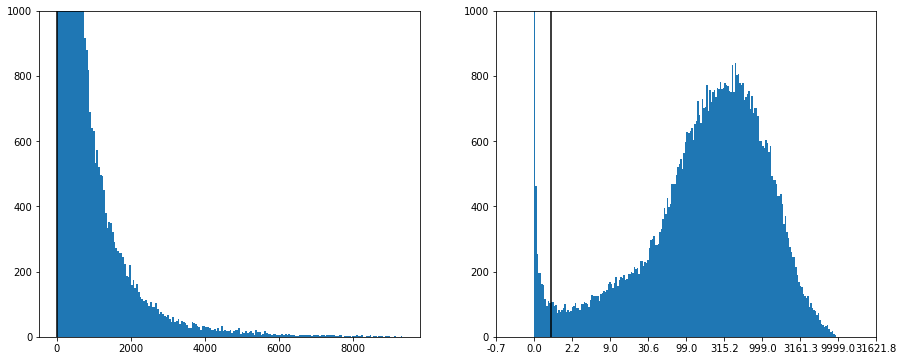

In [189]:
for j in range(10):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    # q_0
    Q_0_colour_est = numbers_lofar_combined_bins/len(lofar) ### Q_0
    Q_0_colour = q0_min_level(Q_0_colour_est, min_level=0.001)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    # q_m_old
    q_m_old = []
    # W1 only sources
    q_m_old.append(get_q_m(lofar["W1mag"][lofar["category"] == 0], 
                   bin_list_w1, numbers_lofar_combined_bins[0], 
                   n_m_old[0], field.area, radius=radius))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m_old.append(get_q_m(lofar["i"][lofar["category"] == i], 
                       bin_list_i, numbers_lofar_combined_bins[i],
                       n_m_old[i], field.area, radius=radius))
    # q_m
    q_m = []
    # W1 only sources
    q_m.append(get_q_m_kde(lofar["W1mag"][lofar["category"] == 0], 
                   centers[0], radius=radius, bandwidth=bandwidth_colour[0]))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m_kde(lofar["i"][lofar["category"] == i], 
                       centers[i], radius=radius, bandwidth=bandwidth_colour[i]))
    # Save new parameters
    if save_intermediate:
        pickle.dump([bin_list, centers, Q_0_colour, n_m_old, q_m_old], 
                    open("{}/lofar_params_cumsum_{}.pckl".format(idp, iteration), 'wb'))
        pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                    open("{}/lofar_params_{}.pckl".format(idp, iteration), 'wb'))
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k)
        plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k/n_m[i])
        plt.savefig('{}/q_over_n_{}.png'.format(idp, iteration))
        del fig
        fig = plot_q_n_m(q_m, n_m)
        plt.savefig('{}/q_over_n_nice_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimatorU(Q_0_colour, n_m, q_m, centers)
    def ml(i):
        return apply_ml(i, likelihood_ratio)
    ## Run the ML
    res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)
    lofar["lr_index_{}".format(iteration)] = np.nan
    lofar["lr_dist_{}".format(iteration)] = np.nan
    lofar["lr_{}".format(iteration)] = np.nan
    (lofar["lr_index_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_dist_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_{}".format(iteration)][idx_lofar_unique]) = list(map(list, zip(*res)))
    lofar["lr_{}".format(iteration)][np.isnan(lofar["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold
    threshold = np.percentile(lofar["lr_{}".format(iteration)], 100*(1 - q0_total))
    #threshold = get_threshold(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)])
    print("Threshold: ", threshold)
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold
    lofar["lr_index_sel_{}".format(iteration)] = lofar["lr_index_{}".format(iteration)]
    lofar["lr_index_sel_{}".format(iteration)][lofar["lr_{}".format(iteration)] < threshold] = np.nan
    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar["W1mag"] = np.nan
    lofar["i"] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_sel_{}".format(iteration)])
    indices = lofar["lr_index_sel_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = combined[indices]["category"]
    lofar["W1mag"][c] = combined[indices]["W1mag"]
    lofar["i"][c] = combined[indices]["i"]
    # Save the data
    if save_intermediate:
        lofar.write("{}/lofar_m{}.fits".format(idp, iteration), format="fits")
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    t_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]))
    print("T changes: ", t_changes)
    ## Check changes
    if n_changes == 0:
        break
    else:
        print("******** continue **********")

In [164]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

array([19588,  3729,    83,   518,  2295,  3282,  4700,  5248,  5054,
        4569,  4370,  3851,  3313,  4410,  1679,   540])

In [165]:
if save_intermediate:
    pickle.dump([numbers_lofar_combined_bins, numbers_combined_bins], 
                open("{}/numbers_{}.pckl".format(idp, iteration), 'wb'))

In [167]:
good = False

In [193]:
if good:
    if os.path.exists("lofar_params.pckl"):
        os.remove("lofar_params.pckl")
    copyfile("{}/lofar_params_{}.pckl".format(idp, iteration), "lofar_params.pckl")